In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("data_set.csv")
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
X_all = df[[feat for feat in df.columns if feat != "Stroke"]]
Y_all = df["Stroke"]

[Text(0, 0, '243388'), Text(0, 0, '10292')]

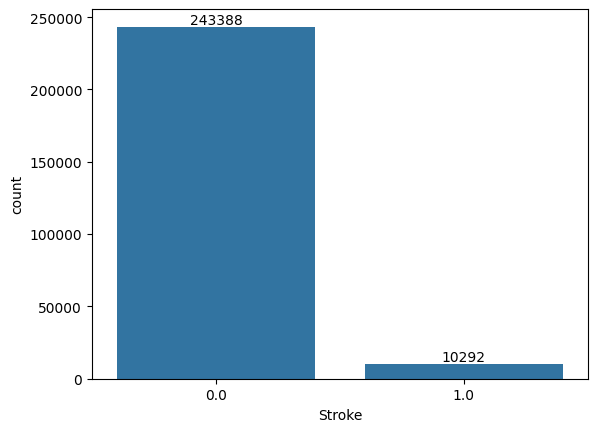

In [4]:
ax=sns.countplot(data=df, x="Stroke")
ax.bar_label(ax.containers[0])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# Dados reservados para validação final do modelo
X, X_test, Y, y_test = train_test_split(X_all, Y_all, test_size=0.1, random_state=416, stratify=Y_all)

[Text(0, 0, '219049'), Text(0, 0, '9263')]

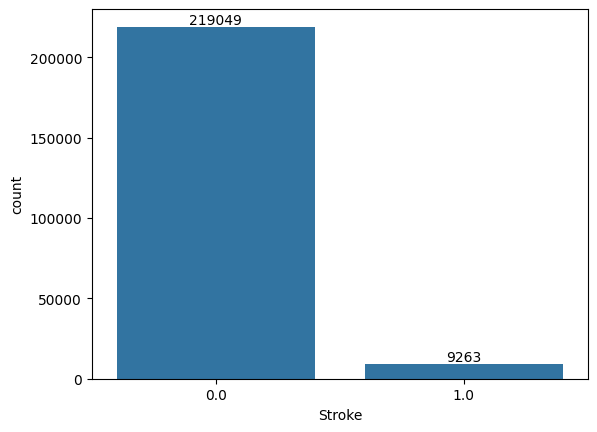

In [7]:
ax=sns.countplot(data=df.iloc[Y.index], x="Stroke")
ax.bar_label(ax.containers[0])

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


Fazendo testes de mudanças de parâmetros com auxílio de GridSearch

In [16]:
parameters = {'n_estimators':(50, 100, 200), 'criterion': ("gini", 'entropy'), "max_depth": (5,10,None)}

In [23]:
classifier = RandomForestClassifier(class_weight="balanced")
gridsearch = GridSearchCV(classifier, parameters, cv=5, n_jobs=8, scoring="balanced_accuracy", verbose=0)
gridsearch.fit(X, Y)

/home/jmg/Documents/Unicamp/2024.1/IA/env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=8,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': (5, 10, None),
                         'n_estimators': (50, 100, 200)},
             scoring='balanced_accuracy')

In [24]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by=["mean_test_score"], ascending=False,).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.374860,0.385231,0.112651,0.020757,gini,5.0,50,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.752833,0.753749,0.749519,0.744897,0.745215,0.749243,0.003698,1
1,6.112740,0.341716,0.201419,0.046316,gini,5.0,100,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.755376,0.750536,0.748238,0.745971,0.744552,0.748935,0.003809,2
2,11.867785,1.041218,0.334739,0.052712,gini,5.0,200,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.753345,0.754436,0.747025,0.745702,0.742359,0.748574,0.004613,3
11,11.665157,0.851490,0.323939,0.017539,entropy,5.0,200,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",0.751170,0.752262,0.747971,0.747021,0.741916,0.748068,0.003637,4
10,5.823437,0.630681,0.196321,0.037659,entropy,5.0,100,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",0.749542,0.751976,0.744892,0.747705,0.742690,0.747361,0.003289,5


Avaliando cutoff ótimo

In [43]:
from tqdm import tqdm
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score,classification_report ,confusion_matrix,balanced_accuracy_score

In [10]:
mccs, balan_accs, f1s = [],[],[]
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = RandomForestClassifier(class_weight="balanced", max_depth=5, n_estimators=100, criterion="gini")
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_val)
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")

ACC Balanceada: 0.7491 +- 0.0036
MCC: 0.2182 +- 0.0029
F1: 0.1908 +- 0.0018


In [21]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [52]:
mccs, balan_accs, f1s = [],[],[]
cms = []
thresholds = np.arange(0, 1, 0.01)
melhores_tresholds = []
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = RandomForestClassifier(class_weight="balanced", max_depth=5, n_estimators=100, criterion="gini")
    clf.fit(X_train, Y_train)
    # y_pred = clf.predict(X_val)
    y_pred_proba_train = clf.predict_proba(X_train)
    scores = [matthews_corrcoef(Y_train, to_labels(y_pred_proba_train, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_tresholds.append(thresholds[melhor_treshold])
    y_pred_proba = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_proba, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    cms.append(confusion_matrix(Y_val, y_pred))

100%|█████████████████████████████████████████| 100/100 [20:28<00:00, 12.28s/it]


In [53]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")

ACC Balanceada: 0.6984 +- 0.0183
MCC: 0.2275 +- 0.0043
F1: 0.2358 +- 0.0094


In [54]:
cms = np.array(cms)

<Axes: >

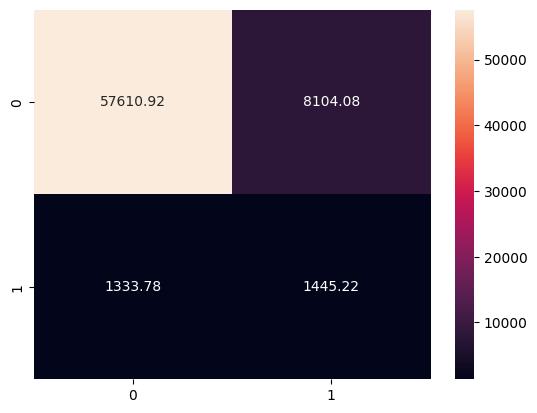

In [63]:
sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")